### 1. Install and import data

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create data directory and unzip images
celeba_zip_path = "/content/drive/MyDrive/img_align_celeba.zip"
if os.path.exists(celeba_zip_path):
    print("Unzipping CelebA images...")
    !mkdir -p ./data/celeba
    !unzip -q "{celeba_zip_path}" -d ./data/celeba/
    print("Done.")
else:
    print(f"Warning: CelebA zip file not found at {celeba_zip_path}")

# Copy attribute files
print("Copying attribute files...")
!cp "/content/drive/MyDrive/celeba/list_attr_celeba.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_eval_partition.txt" ./data/celeba/
print("Done.")

# Verify whether the file exists
print("\nFiles in ./data/celeba/:")
!ls ./data/celeba

Mounted at /content/drive
Unzipping CelebA images...
Done.
Copying attribute files...
Done.

Files in ./data/celeba/:
img_align_celeba  list_attr_celeba.txt	list_eval_partition.txt


In [ ]:
!pip install torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install diffusers transformers einops accelerate

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
from diffusers import AutoencoderKL
from torchvision.utils import make_grid
import torchvision.utils as vutils
from tqdm.auto import tqdm
from typing import Callable
import os
import pandas as pd
from typing import Tuple, List
import clip
from torchvision.transforms import ToPILImage
from tqdm import trange

In [ ]:
!pip install facenet-pytorch

In [ ]:
from facenet_pytorch import InceptionResnetV1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### 2. Model Loading
This section loads the pre-trained VAE, CLIP, and a VGGFace2-based face recognition model for Identity Loss computation.

2.1 VAE: AutoencoderKL

In [ ]:
# AutoencoderKL
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device)
vae.eval()

# Image preprocessing
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(256),  # VAE performs better at 256x256
    transforms.ToTensor(),
])

# Encoder: Image to Latent
def encode_batch(imgs):
    x = imgs * 2 - 1
    with torch.no_grad():
        dist = vae.encode(x.to(device)).latent_dist
        z = dist.sample()
    return z

# Decoder: Latent to Image
def decode_latent(z):
    out = vae.decode(z).sample
    img = (out / 2 + 0.5).clamp(0, 1)
    return img

2.2 Pretrained CLIP

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

# The image preprocessing for CLIP is fixed to 224x224
clip_img_preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

# Extract CLIP features for image and text
def get_clip_features(image_tensor, text_prompt):
    # Get features for image
    image_features = clip_model.encode_image(clip_img_preprocess(image_tensor).to(device))
    image_features = F.normalize(image_features, dim=-1)

    # Get features for text
    text_tokens = clip.tokenize(text_prompt).to(device)
    text_features = clip_model.encode_text(text_tokens)
    text_features = F.normalize(text_features, dim=-1)

    return image_features, text_features

2.3 Identity Loss Model

In [ ]:
# Load pretrained InceptionResnetV1 model for identity loss
identity_loss_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Image preprocessing
image_preprocess = transforms.Compose([
    transforms.Resize(160)
])

# Define identity loss function
def identity_loss(source_img, edited_img):
    # Only want to stop gradient for source_img
    with torch.no_grad():
        source_emb = identity_loss_model(image_preprocess(source_img))

    # Need to compute gradients for edited_emb
    edited_emb = identity_loss_model(image_preprocess(edited_img))

    # Compute similarity loss
    return 1 - F.cosine_similarity(source_emb, edited_emb).mean()

### 3. Latent Optimization

3.1 Select input images manually

In [ ]:
def sample_attr_paths(root: str, attr_name: str, N: int, positive: bool = True) -> List[str]:
    attr_path = os.path.join(root, 'list_attr_celeba.txt')
    img_dir   = os.path.join(root, 'img_align_celeba')

    df = pd.read_csv(attr_path, sep='\s+', header=1, index_col=0)

    target_val = 1 if positive else -1
    sub_df = df[df[attr_name] == target_val]

    if len(sub_df) < N:
        raise ValueError(f"not enough {N} samples for {attr_name}={target_val}")

    file_list = random.sample(list(sub_df.index), N)
    paths = [os.path.join(img_dir, fn) for fn in file_list]
    return paths

class SimpleCelebA(Dataset):
    def __init__(self, paths: List[str], transform):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.transform(img)

In [ ]:
N_SAMPLES = 3
BATCH_SIZE = 1

In [ ]:
# Select images to add a smiling face

attr_path = './data/celeba/list_attr_celeba.txt'
df = pd.read_csv(attr_path, sep='\s+', header=1, index_col=0)

# Multi-condition filtering
cond = (
    (df['Smiling'] == -1) &
    (df['Mouth_Slightly_Open'] == -1) &
    (df['Blurry'] == -1) &
    (df['Eyeglasses'] == -1) &
    (df['Wearing_Hat'] == -1)
)
filtered = df[cond]
print(f"Number of available images: {len(filtered)}")

Number of available images: 67627


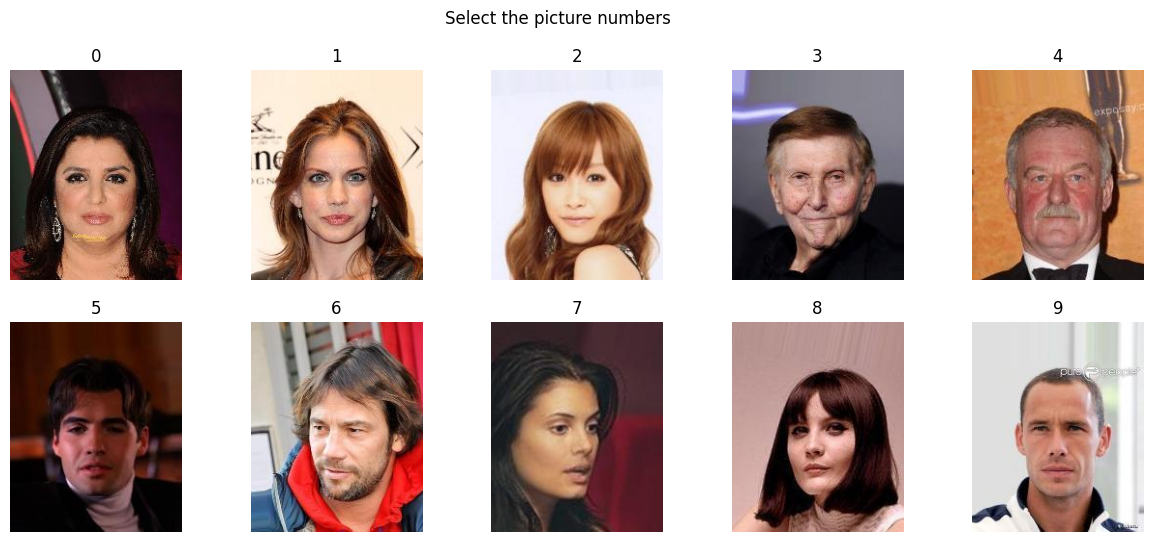

In [ ]:
# Randomly sample 10 images for manual selection
sampled_filenames = random.sample(list(filtered.index), 10)
img_dir = './data/celeba/img_align_celeba/'   # Change to another folder
sampled_paths = [img_dir + fn for fn in sampled_filenames]

plt.figure(figsize=(15, 6))
for i, path in enumerate(sampled_paths):
    img = Image.open(path).convert('RGB')
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(str(i))  # Use numbers 0–9 as labels
plt.suptitle("Select the picture numbers")
plt.show()

In [ ]:
selected_idx = [2, 4, 9]
final_paths = [sampled_paths[i] for i in selected_idx]
print("Path：", final_paths)
source_loader = DataLoader(SimpleCelebA(final_paths, transform), batch_size=BATCH_SIZE, shuffle=False)

Path： ['./data/celeba/img_align_celeba/021157.jpg', './data/celeba/img_align_celeba/003426.jpg', './data/celeba/img_align_celeba/014011.jpg']


3.2 Latent Optimization function

In [1]:
def latent_optimization_edit(
    source_img,
    text_prompt,
    l2_lambda=0.008,
    id_lambda=0.005,
    steps=200,
    lr=0.01
):
    # Get the original latent variable
    z_s = encode_batch(source_img)
    z_s.requires_grad = False

    # Initialize the latent variable to be optimized
    z_editable = z_s.clone()
    z_editable.requires_grad = True
    print(z_s.device, z_editable.device)

    # Set up the optimizer
    optimizer = torch.optim.Adam([z_editable], lr=lr)

    print(f"Optimizing for text prompt: '{text_prompt}'...")
    pbar = range(steps)
    for step in pbar:
        optimizer.zero_grad()

        # Decode image from the current latent variable
        edited_img = decode_latent(z_editable)

        # Compute losses
        img_feats, txt_feats = get_clip_features(edited_img, text_prompt)
        clip_loss = 1 - torch.cosine_similarity(img_feats, txt_feats).mean()
        l2_loss = F.mse_loss(z_editable, z_s)
        id_loss = identity_loss(source_img, edited_img)
        total_loss = clip_loss + l2_lambda * l2_loss + id_lambda * id_loss

        # Print debug info every 20 steps
        if step % 20 == 0 or step == steps - 1:
            # Average change in latent variable
            latent_diff = (z_editable - z_s).abs().mean().item()
            print(
                f"[step {step}] total_loss={total_loss.item():.4f} "
                f"clip_loss={clip_loss.item():.4f} "
                f"l2_loss={l2_loss.item():.4f} "
                f"id_loss={id_loss.item():.4f} "
                f"latent_diff={latent_diff:.6f} "
                f"img min/max={edited_img.min().item():.3f}/{edited_img.max().item():.3f}"
            )

        # Backpropagation and optimization
        total_loss.backward()
        optimizer.step()

    return z_editable


def compare_reconstruction(img_orig, img_recon, img_edited, n=5):
    img_orig = img_orig.cpu()
    img_recon = img_recon.cpu()
    img_edited = img_edited.cpu()

    plt.figure(figsize=(n*3, 9))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(img_orig[i].permute(1,2,0).numpy().clip(0,1))
        plt.axis('off')
        if i == 0: plt.title('Original')

        plt.subplot(3, n, n+i+1)
        plt.imshow(img_recon[i].detach().permute(1,2,0).numpy().clip(0,1))
        plt.axis('off')
        if i == 0: plt.title('VAE Recon')

        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(img_edited[i].detach().permute(1,2,0).numpy().clip(0,1))
        plt.axis('off')
        if i == 0: plt.title('Edited')
    plt.show()

3.3 Perform editing and visualize the results

cuda:0 cuda:0
Optimizing for text prompt: 'smiling face'...
[step 0] total_loss=0.7598 clip_loss=0.7598 l2_loss=0.0000 id_loss=0.0062 latent_diff=0.000000 img min/max=0.000/1.000
[step 20] total_loss=0.7452 clip_loss=0.7451 l2_loss=0.0085 id_loss=0.0077 latent_diff=0.089802 img min/max=0.000/1.000
[step 40] total_loss=0.7346 clip_loss=0.7344 l2_loss=0.0285 id_loss=0.0091 latent_diff=0.160287 img min/max=0.000/1.000
[step 60] total_loss=0.7270 clip_loss=0.7266 l2_loss=0.0539 id_loss=0.0101 latent_diff=0.214187 img min/max=0.000/1.000
[step 80] total_loss=0.7195 clip_loss=0.7188 l2_loss=0.0850 id_loss=0.0114 latent_diff=0.263028 img min/max=0.000/1.000
[step 100] total_loss=0.7105 clip_loss=0.7095 l2_loss=0.1231 id_loss=0.0137 latent_diff=0.311346 img min/max=0.000/1.000
[step 120] total_loss=0.7035 clip_loss=0.7021 l2_loss=0.1629 id_loss=0.0156 latent_diff=0.353732 img min/max=0.000/1.000
[step 140] total_loss=0.6970 clip_loss=0.6953 l2_loss=0.2016 id_loss=0.0170 latent_diff=0.390126 im

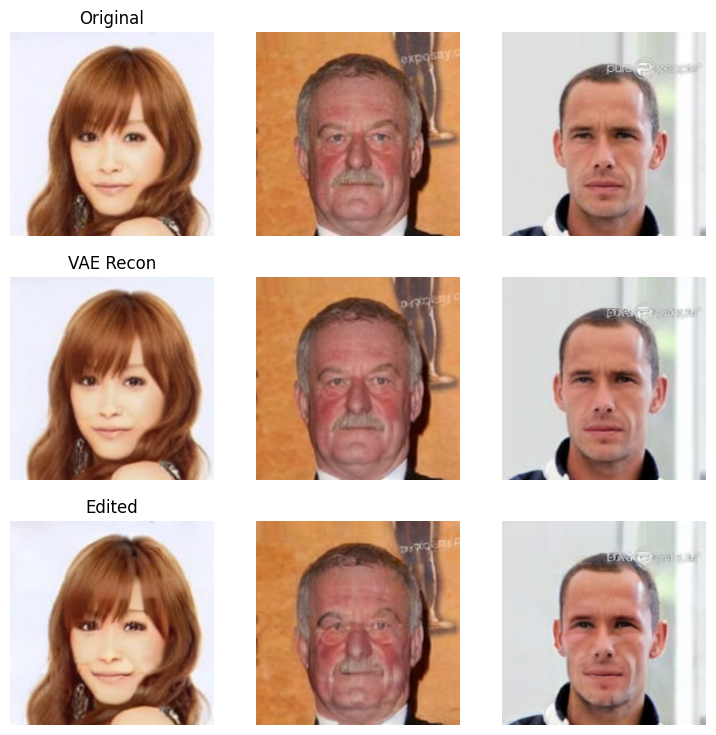

In [ ]:
TARGET_PROMPT = "smiling face"
LAMBDA_L2 = 0.008
LAMBDA_ID = 0.005

original_images = []
recon_images = []
edited_images = []

for i, source_batch in enumerate(source_loader):
    if i >= N_SAMPLES:
        break

    source_img_tensor = source_batch.to(device)

    # Run the optimization
    edited_latent = latent_optimization_edit(
        source_img=source_img_tensor,
        text_prompt=TARGET_PROMPT,
        l2_lambda=LAMBDA_L2,
        id_lambda=LAMBDA_ID,
        steps=200,
        lr=0.005
    )

    # Decode the final results
    original_img = source_img_tensor
    recon_img = decode_latent(encode_batch(original_img))
    edited_img = decode_latent(edited_latent)

    # For each image, output the reconstruction and check latent difference
    latent_orig = encode_batch(original_img)
    latent_diff_final = (edited_latent - latent_orig).abs().mean().item()
    print(f"[IMAGE {i}] final latent mean abs diff: {latent_diff_final:.6f}")
    print(f"[IMAGE {i}] original_img min/max: {original_img.min().item():.3f}/{original_img.max().item():.3f}")
    print(f"[IMAGE {i}] recon_img min/max: {recon_img.min().item():.3f}/{recon_img.max().item():.3f}")
    print(f"[IMAGE {i}] edited_img min/max: {edited_img.min().item():.3f}/{edited_img.max().item():.3f}")

    # Use .detach().cpu() to avoid occupying GPU memory
    original_images.append(original_img.detach().cpu())
    recon_images.append(recon_img.detach().cpu())
    edited_images.append(edited_img.detach().cpu())

    # Free up unused GPU memory
    del edited_latent, original_img, recon_img, edited_img
    torch.cuda.empty_cache()

original_images = torch.cat(original_images, dim=0)
recon_images = torch.cat(recon_images, dim=0)
edited_images = torch.cat(edited_images, dim=0)


# Visualization
print("\nDisplaying results...")
compare_reconstruction(original_images, recon_images, edited_images, n=N_SAMPLES)